# Collecting Images on the hand signs from kaggle


## Preprocessing and Dataset Creation with Pytorch

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px

In [2]:
DATA_PATH = '/kaggle/input/indian-sign-language-dataset/data'

In [3]:
categories = sorted(os.listdir(DATA_PATH))
print(f"Categories: {categories}")

Categories: ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [5]:
class SignLanguageDataset(Dataset):
    def __init__(self, data_path, categories, img_size=(64, 64), transform=None):
        self.data_path = data_path
        self.categories = categories
        self.img_size = img_size
        self.transform = transform
        self.images = []
        self.labels = []
        self.load_images_and_labels()

    def load_images_and_labels(self):
        for category in self.categories:
            category_path = os.path.join(self.data_path, category)
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, self.img_size)
                if self.transform:
                    img = self.transform(img)
                else:
                    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1) / 255.0
                self.images.append(img)
                self.labels.append(category)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjust mean and std if necessary
])

In [7]:
dataset = SignLanguageDataset(DATA_PATH, categories, transform=transform)

In [8]:
# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [9]:
# DataLoader for batching
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
class SignLanguageCNN(nn.Module):
    def __init__(self, num_classes):
        super(SignLanguageCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# import torch
# import torch.nn as nn

# class SignLanguageCNN(nn.Module):
#     def __init__(self, num_classes):
#         super(SignLanguageCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = None  # To be defined dynamically based on input size
#         self.fc2 = nn.Linear(512, num_classes)
#         self.dropout = nn.Dropout(0.5)
#         self.relu = nn.ReLU()

#     def _get_conv_output(self, shape):
#         """Helper function to calculate the output size of the conv layers."""
#         with torch.no_grad():
#             x = torch.zeros(1, *shape)
#             x = self.pool(self.relu(self.conv1(x)))
#             x = self.pool(self.relu(self.conv2(x)))
#             x = self.pool(self.relu(self.conv3(x)))
#             return x.view(1, -1).size(1)

#     def forward(self, x):
#         if self.fc1 is None:
#             conv_output_size = self._get_conv_output(x.shape[1:])
#             self.fc1 = nn.Linear(conv_output_size, 512).to(x.device)

#         x = self.pool(self.relu(self.conv1(x)))
#         x = self.pool(self.relu(self.conv2(x)))
#         x = self.pool(self.relu(self.conv3(x)))
#         x = x.view(x.size(0), -1)
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x


In [11]:
num_classes = len(categories)
model = SignLanguageCNN(num_classes)

In [12]:
num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
from tqdm import tqdm

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    
    for images, labels in train_loader_tqdm:
        images = images.to(device)
        labels = torch.tensor([categories.index(label) for label in labels]).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update tqdm with the current loss
        train_loader_tqdm.set_postfix({"Loss": running_loss / len(train_loader)})

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_loader_tqdm = tqdm(val_loader, desc="Validation", unit="batch", leave=False)

    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images = images.to(device)
            labels = torch.tensor([categories.index(label) for label in labels]).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update tqdm with the current validation loss and accuracy
            val_loader_tqdm.set_postfix({"Val Loss": val_loss / len(val_loader), 
                                         "Accuracy": 100 * correct / total})

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, '
          f'Validation Loss: {val_loss / len(val_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')


Epoch 1/1: 100%|██████████| 919/919 [02:51<00:00,  5.37batch/s, Loss=0.135]
                                                                                                 

Epoch [1/1], Loss: 0.1346, Validation Loss: 0.0007, Accuracy: 99.97%


In [14]:
# Test the model
model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = torch.tensor([categories.index(label) for label in labels]).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {100 * correct / total:.2f}%')

Test Loss: 0.0021, Test Accuracy: 99.92%


In [15]:

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=categories))


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       182
           2       1.00      1.00      1.00       190
           3       1.00      1.00      1.00       162
           4       1.00      1.00      1.00       193
           5       1.00      1.00      1.00       181
           6       1.00      1.00      1.00       178
           7       1.00      1.00      1.00       169
           8       1.00      1.00      1.00       189
           9       1.00      1.00      1.00       148
           A       1.00      1.00      1.00       166
           B       1.00      1.00      1.00       190
           C       1.00      1.00      1.00       175
           D       1.00      1.00      1.00       164
           E       1.00      1.00      1.00       169
           F       0.99      1.00      1.00       174
           G       1.00      1.00      1.00       187
           H       1.00      1.00      1.00       180
   

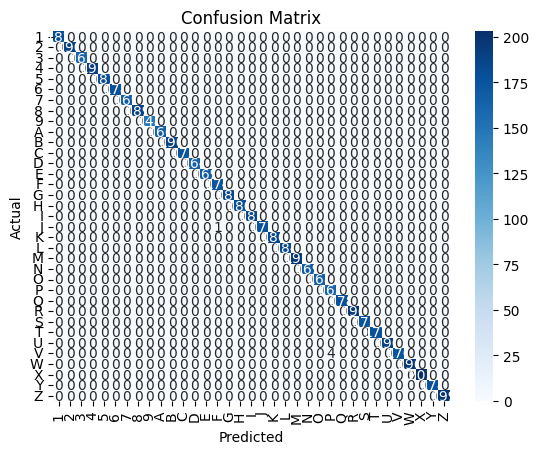

In [16]:
# Confusion matrix
conf_mat = confusion_matrix(all_labels, all_predictions)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

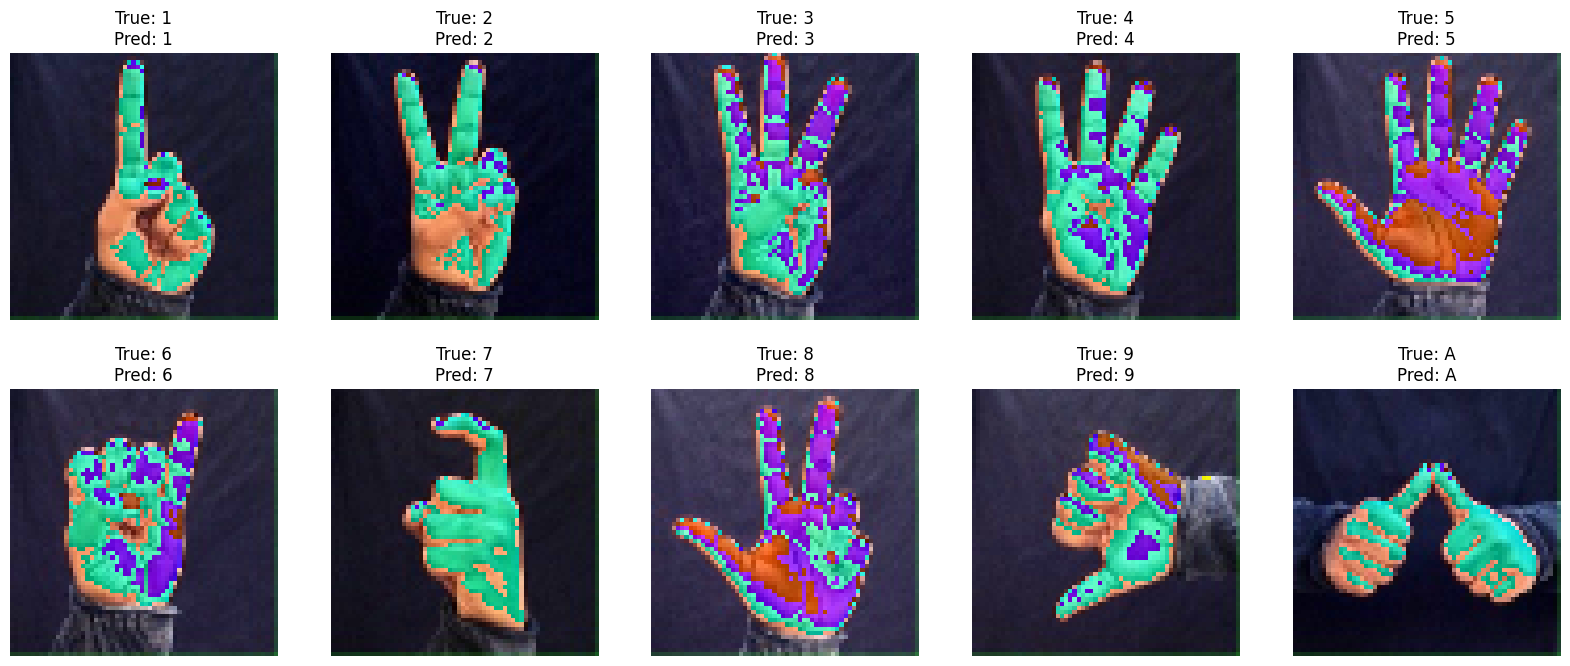

In [17]:
import matplotlib.pyplot as plt
import torch

# Set the model to evaluation mode
model.eval()

# Create a dictionary to store samples for each class
class_samples = {category: None for category in categories}

# Find one sample for each class
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = torch.tensor([categories.index(label) for label in labels]).to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for img, label, pred in zip(images, labels, predicted):
            label_name = categories[label.item()]
            if class_samples[label_name] is None:
                class_samples[label_name] = (img.cpu(), categories[pred.item()])
            if all(class_samples.values()):
                break

# Display the sample predictions
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, (ax, category) in enumerate(zip(axes.flat, categories)):
    img, pred_label = class_samples[category]
    img = img.permute(1, 2, 0).numpy()  # Convert to HWC format
    img = (img * 255).astype(np.uint8)  # De-normalize if necessary

    ax.imshow(img)
    ax.set_title(f"True: {category}\nPred: {pred_label}")
    ax.axis('off')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import torch

# Set the model to evaluation mode
model.eval()

# Create a dictionary to store samples for each class
class_samples = {category: None for category in categories}

# Find one sample for each class
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = torch.tensor([categories.index(label) for label in labels]).to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for img, label, pred in zip(images, labels, predicted):
            label_name = categories[label.item()]
            if class_samples[label_name] is None:
                class_samples[label_name] = (img.cpu(), categories[pred.item()])
            if all(class_samples.values()):
                break

# Determine the number of rows and columns based on the total number of classes
num_classes = len(categories)
rows = (num_classes + 4) // 5  # This ensures enough rows to accommodate all classes
cols = 5

# Display the sample predictions
fig, axes = plt.subplots(rows, cols, figsize=(20, 4 * rows))
axes = axes.flatten()

for i, category in enumerate(categories):
    img, pred_label = class_samples[category]
    img = img.permute(1, 2, 0).numpy()  # Convert to HWC format
    img = (img * 255).astype(np.uint8)  # De-normalize if necessary

    ax = axes[i]
    ax.imshow(img)
    ax.set_title(f"True: {category}\nPred: {pred_label}")
    ax.axis('off')

# Turn off any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [19]:
# Save the model's state dictionary
model_save_path = "/kaggle/working/indian_sign_language_model.pth"
torch.save(model.state_dict(), model_save_path)

In [20]:
# Save the entire model
model_save_path = "/kaggle/working/indian_sign_language_model_full.pth"
torch.save(model, model_save_path)